In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from Bio.SeqIO.FastaIO import SimpleFastaParser
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize, MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
input_hot = 'hot_regions_01_all.fa'
input_lot = 'lot_regions_01_all.fa'
kmer_length = 4
sampling_percentage = 1
seed = 35

In [3]:
with open(input_hot) as fasta_file:
    hot_sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        hot_sequences.append(sequence.upper())

with open(input_lot) as fasta_file:
    lot_sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        lot_sequences.append(sequence.upper())

In [4]:
df_hot = pd.DataFrame(hot_sequences, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences, columns=['sequence'])
df_lot['label'] = 0

temp = pd.concat([df_hot, df_lot], ignore_index=True)
temp['len'] = temp.apply(lambda a: len(a['sequence']), axis=1)
temp.label.value_counts()

0    1512
1    1505
Name: label, dtype: int64

In [5]:
temp.head()

,sequence,label,len
0,AGTTTTCTATTTTTGACCAACATAAACACTGTGCTGGGTCTGAATT...,1,797
1,ACACAGCTCGCGCCCCGAGGCTCCCAAGCCCCCGACGCGGGCGGTG...,1,813
2,GGGTCCACGCTTACGGTCCTCATGTTCTTTTTCTTCAGGTATCGGG...,1,796
3,CCCGGCCCCGTCCACGCCCCGCAAGAGGAGCTCGCTGGCCCCGCCA...,1,717
4,TCTTCCCGGCTAGGAGCCCGCGGGGGGCGACCCCCTGCAGGGCTTG...,1,889


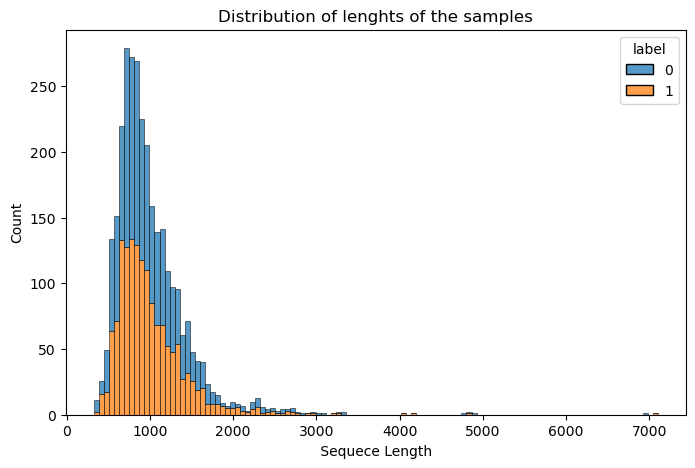

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(data=temp, x="len", hue="label", multiple="stack")
plt.title("Distribution of lenghts of the samples")
plt.xlabel(" Sequece Length ")
plt.ylabel("Count")
plt.show()

In [7]:
df_resample = temp.copy()

def kmers(seq, length):
    return [seq[i:i+length] for i in range(len(seq)-length+1)]

df_resample['kmers'] = df_resample.apply(lambda a: kmers(a['sequence'], kmer_length), axis=1)
df_resample.drop('sequence',axis=1, inplace=True)
df_resample = df_resample.reset_index()
df_resample.drop('index', axis=1, inplace=True)
df_resample.head()

,label,len,kmers
0,1,797,"[AGTT, GTTT, TTTT, TTTC, TTCT, TCTA, CTAT, TAT..."
1,1,813,"[ACAC, CACA, ACAG, CAGC, AGCT, GCTC, CTCG, TCG..."
2,1,796,"[GGGT, GGTC, GTCC, TCCA, CCAC, CACG, ACGC, CGC..."
3,1,717,"[CCCG, CCGG, CGGC, GGCC, GCCC, CCCC, CCCG, CCG..."
4,1,889,"[TCTT, CTTC, TTCC, TCCC, CCCG, CCGG, CGGC, GGC..."


In [8]:
kmer_seqs = list(df_resample['kmers'])
for x in range(len(kmer_seqs)):
    kmer_seqs[x] = ' '.join(kmer_seqs[x])

labels = df_resample['label'].tolist()

In [9]:
c = CountVectorizer(ngram_range=(1,1))
x = c.fit_transform(kmer_seqs)


In [55]:
x.toarray()

array([[ 1,  2,  0, ...,  2,  2,  5],
       [13,  1,  2, ...,  4,  2,  2],
       [ 1,  3,  3, ...,  3,  1,  4],
       ...,
       [31,  9,  8, ...,  7,  7, 13],
       [44, 10, 11, ...,  2,  9, 29],
       [ 7,  2,  6, ..., 18, 10, 25]])

In [35]:
count_df = pd.DataFrame(x.toarray(), columns=c.vocabulary_)
count_df['label'] = labels
count_df.head()

count_df = count_df.drop(['cgcn', 'gcnn', 'cnnn', 'nnnn', 'tagn', 'agnn', 'gnnn'], axis=1)

In [37]:
count_df.head()

,agtt,gttt,tttt,tttc,ttct,tcta,ctat,tatt,attt,tttg,...,taat,tgtt,gaca,agta,agat,atgc,atag,ttat,atta,label
0,1,2,0,0,4,4,3,2,1,2,...,0,2,0,0,2,2,1,5,2,1
1,13,1,2,2,0,0,3,1,2,4,...,1,2,1,0,1,10,0,2,1,1
2,1,3,3,1,3,3,3,1,1,0,...,0,1,0,0,4,5,1,3,0,1
3,0,1,1,0,0,1,2,2,1,1,...,0,1,0,0,0,1,3,2,0,1
4,0,0,0,1,0,0,3,0,0,2,...,0,1,1,0,0,9,0,2,0,1


In [48]:
count_matrix = np.array(count_df.iloc[:, :-1], dtype=float)
count_matrix.shape

(3017, 256)

##### The following cell loads the k-mer vectors learned from human dna sequence

In [30]:
import csv
reader = csv.reader(open('pretrained/dna2vec-20161219-0153-k3to8-100d-10c-29320Mbp-sliding-Xat.csv', 'r')) 
kmers_wv = {}
for row in reader:
    k = row[0]
    kmers_wv[k] = row[1:]

In [39]:
wvs = []
for kmer in count_df.columns[:-1]:
    wvs.append(kmers_wv[kmer.upper()])


In [47]:
wvs = np.array(wvs, dtype=float)
wvs.shape

(256, 100)

In [53]:
new_df = np.dot(count_matrix, wvs)
new_df.shape

(3017, 100)

In [65]:
x_normalized = normalize(x, norm='l1')
scaler = MaxAbsScaler()
x_scaled = scaler.fit_transform(x_normalized)
scaled_df_unsorted = pd.DataFrame(x_scaled.toarray(), columns=c.vocabulary_)
scaled_df = scaled_df_unsorted.reindex(sorted(scaled_df_unsorted.columns), axis=1)
scaled_df.head()

,aaaa,aaac,aaag,aaat,aaca,aacc,aacg,aact,aaga,aagc,...,ttcg,ttct,ttga,ttgc,ttgg,ttgt,ttta,tttc,tttg,tttt
0,0.175285,0.146868,0.219144,0.000000,0.042357,0.000000,0.098394,0.094598,0.000000,0.227456,...,0.194342,0.182935,0.104912,0.121411,0.066661,0.000000,0.179138,0.000000,0.192275,0.000000
1,0.171823,0.230346,0.286420,0.124691,0.041520,0.090370,0.096451,0.046365,0.068107,0.594568,...,0.381007,0.000000,0.137119,0.059506,0.000000,0.090370,0.117066,0.073284,0.376955,0.064275
2,0.175506,0.088232,0.438840,0.127364,0.084821,0.000000,0.098518,0.047359,0.208701,0.303657,...,0.291881,0.137374,0.105044,0.121564,0.200234,0.092308,0.478303,0.037427,0.000000,0.098479
3,0.139232,0.065329,0.081232,0.141457,0.000000,0.000000,0.109419,0.078898,0.000000,0.590196,...,0.324176,0.000000,0.194444,0.067507,0.000000,0.000000,0.199209,0.000000,0.106909,0.036458
4,0.269287,0.052647,0.000000,0.113995,0.000000,0.041309,0.088177,0.042388,0.000000,0.339729,...,0.174162,0.000000,0.125357,0.000000,0.059739,0.000000,0.321073,0.033499,0.172310,0.000000


In [68]:
# with embedding vectors

x_normalized = normalize(new_df, norm='l1')
scaler = MaxAbsScaler()
x_scaled2 = scaler.fit_transform(x_normalized)
scaled_df_unsorted = pd.DataFrame(x_scaled2)
scaled_df2 = scaled_df_unsorted.reindex(sorted(scaled_df_unsorted.columns), axis=1)
scaled_df2.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.123511,0.831789,0.339109,-0.546410,-0.662850,0.619562,-0.479562,0.436481,-0.617494,-0.879715,...,-0.515930,0.368438,-0.578985,-0.816635,0.804830,-0.245425,0.775090,-0.532967,-0.816442,-0.189027
1,0.328466,0.883239,0.604963,-0.607676,-0.510214,0.473203,-0.400529,0.394206,-0.586677,-0.822025,...,-0.489247,0.490579,-0.386421,-0.755617,0.784208,-0.280386,0.779282,-0.527477,-0.882310,-0.241343
2,0.204832,0.925452,0.405625,-0.552325,-0.540337,0.485466,-0.478183,0.345255,-0.541835,-0.884326,...,-0.481310,0.464674,-0.513742,-0.866275,0.788566,-0.212676,0.768924,-0.513247,-0.854615,-0.233927
3,0.175867,0.834172,0.504083,-0.564149,-0.527384,0.559173,-0.519379,0.465130,-0.588357,-0.912393,...,-0.530273,0.496471,-0.401088,-0.842291,0.794718,-0.260329,0.809659,-0.574417,-0.903528,-0.193098
4,0.264784,0.908480,0.442718,-0.559689,-0.509220,0.541110,-0.474421,0.501746,-0.498914,-0.906141,...,-0.471803,0.480594,-0.472094,-0.861969,0.780536,-0.188977,0.735612,-0.602643,-0.861187,-0.245890


Accuracy using SVM = 0.9448123620309051
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       227
           1       0.96      0.93      0.94       226

    accuracy                           0.94       453
   macro avg       0.95      0.94      0.94       453
weighted avg       0.95      0.94      0.94       453



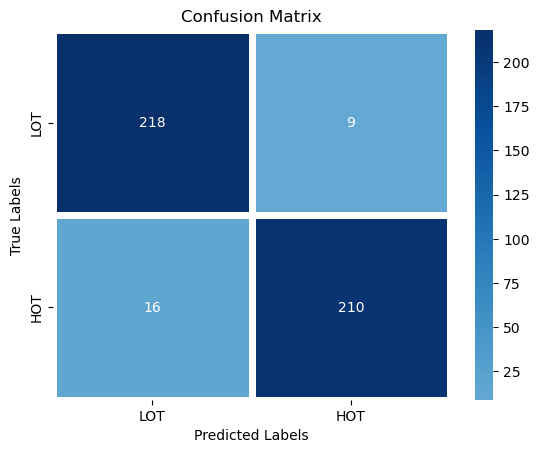

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#clf = SVC(C=1.0, kernel='linear', gamma=0.05)
clf = LogisticRegression()
clf = SVC()

X_train, X_test, Y_train, Y_test = train_test_split(x_scaled, labels, test_size = 0.15, random_state=seed)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print('Accuracy using SVM =', accuracy_score(Y_test, Y_pred))

print(classification_report(Y_test, Y_pred))

cf = confusion_matrix(Y_test, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()